In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models

import numpy as np
import matplotlib.pyplot as plt
import os

from networks import VGG16
import tent

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

True
0
1
NVIDIA GeForce GTX 1070


In [3]:
batch_size = 128
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)
                                    ])
transform_test = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
valset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)

print(trainset.train_data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)


## Network

In [4]:
model = VGG16()

print(sum(p.numel() for p in model.parameters())/1000000, "M parameters")
x = torch.randn(2,3,32,32)
model(x)

14.775446 M parameters


tensor([[ 1.1548, -0.5619, -0.1738,  0.6957, -0.1544, -0.4640, -1.0512,  0.4781,
         -0.3107,  0.1203],
        [ 0.0109, -0.0459, -0.1318,  0.7003, -0.1380, -0.0315, -0.4133, -0.0752,
          0.1881, -0.0451]], grad_fn=<AddmmBackward0>)

## Training

In [5]:
criterion = nn.CrossEntropyLoss() # CE Loss, Takes care of applying softmax
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer
# optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
model = model.to(device)

In [6]:
train_loss_list = []
test_loss_list = []
best_acc = 0

for epoch in range(25):  # num epochs
    
    # Training
    model.train() # Set to train mode
    running_loss = 0.0
    running_corrects = 0

    for i, data in enumerate(trainloader): # Get data batch-wise
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape, inputs.dtype)
        # labels = labels.type(torch.LongTensor)

        # zero out gradients
        optimizer.zero_grad()

        outputs = model(inputs) # forward pass
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels) # Get loss
        loss.backward() # Backward pass
        optimizer.step() # Optimize model weights

        _, preds = torch.max(outputs, 1) # Get predictions
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Get loss and accuracy
    train_loss = (running_loss / len(trainset))
    train_loss_list.append(train_loss.item())
    train_accuracy = (running_corrects.float() / len(trainset))

    # Testing
    model.eval() # Set to eval mode
    running_loss = 0.0
    running_corrects = 0
    y = []; yhat = []

    for i, data in enumerate(valloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.type(torch.LongTensor)

        # forward + backward + optimize
        with torch.no_grad(): # Don't build computation graph for testing
            outputs = model(inputs)
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        y.append(labels.tolist())
        yhat.append(preds.tolist())
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    # Get loss and accuracy
    test_loss = (running_loss / len(valset))
    test_loss_list.append(test_loss.item())
    test_accuracy = (running_corrects.float() / len(valset))

    acc = test_accuracy.item()
    if(acc > best_acc):
        best_acc = acc
        torch.save(model.state_dict(),"checkpoint/vgg16_bn.pth")

    # Display loss, accuracy values after each epoch
    print("Epoch:{} | Train loss: {:.4f} | Test loss: {:.4f} | Train acc.: {:.4f} | Test acc.: {:.4f}\n"
              .format(epoch, train_loss.item(),test_loss.item(),train_accuracy.item(),test_accuracy.item()))


Epoch:0 | Train loss: 1.8204 | Test loss: 1.6558 | Train acc.: 0.2832 | Test acc.: 0.3710

Epoch:1 | Train loss: 1.5269 | Test loss: 1.5052 | Train acc.: 0.3988 | Test acc.: 0.4357

Epoch:2 | Train loss: 1.3459 | Test loss: 1.3613 | Train acc.: 0.4910 | Test acc.: 0.5312

Epoch:3 | Train loss: 1.1869 | Test loss: 1.0034 | Train acc.: 0.5706 | Test acc.: 0.6404

Epoch:4 | Train loss: 1.0531 | Test loss: 0.8710 | Train acc.: 0.6315 | Test acc.: 0.7016

Epoch:5 | Train loss: 0.9303 | Test loss: 0.9634 | Train acc.: 0.6842 | Test acc.: 0.6780

Epoch:6 | Train loss: 0.8464 | Test loss: 0.6823 | Train acc.: 0.7199 | Test acc.: 0.7687

Epoch:7 | Train loss: 0.7620 | Test loss: 0.6659 | Train acc.: 0.7511 | Test acc.: 0.7814

Epoch:8 | Train loss: 0.7076 | Test loss: 0.6465 | Train acc.: 0.7727 | Test acc.: 0.7919

Epoch:9 | Train loss: 0.6521 | Test loss: 0.6335 | Train acc.: 0.7947 | Test acc.: 0.8015

Epoch:10 | Train loss: 0.6090 | Test loss: 0.5677 | Train acc.: 0.8115 | Test acc.: 0.8202

## Inference

In [9]:
model = VGG16().to(device)
model.load_state_dict(torch.load("checkpoint/vgg16_bn.pth"))

<All keys matched successfully>

### CIFAR10

In [10]:
# Testing
model.eval() # Set to eval mode
running_loss = 0.0
running_corrects = 0
y = []; yhat = []

for i, data in enumerate(valloader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # labels = labels.type(torch.LongTensor)

    # forward + backward + optimize
    with torch.no_grad(): # Don't build computation graph for testing
        outputs = model(inputs)
    # print(outputs.shape, labels.shape)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    y.append(labels.tolist())
    yhat.append(preds.tolist())
    running_loss += loss.detach() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

# Get loss and accuracy
test_loss = (running_loss / len(valset))
test_loss_list.append(test_loss.item())
test_accuracy = (running_corrects.float() / len(valset))

# Display loss, accuracy values after each epoch
print("Test loss: {:.4f} | Test acc.: {:.4f}\n"
            .format(test_loss.item(),test_accuracy.item()))

Test loss: 0.3906 | Test acc.: 0.8833



In [11]:
# TENT

model = tent.configure_model(model)
params, param_names = tent.collect_params(model)
optimizer = torch.optim.Adam(params, lr=1e-3)
tented_model = tent.Tent(model, optimizer)

tented_model = tented_model.to(device)

In [12]:

# Testing
tented_model.eval() # Set to eval mode
running_loss = 0.0
running_corrects = 0
y = []; yhat = []

for i, data in enumerate(valloader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # labels = labels.type(torch.LongTensor)

    # forward + backward + optimize
    with torch.no_grad(): # Don't build computation graph for testing
        outputs = tented_model(inputs)
    # print(outputs.shape, labels.shape)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    y.append(labels.tolist())
    yhat.append(preds.tolist())
    running_loss += loss.detach() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

# Get loss and accuracy
test_loss = (running_loss / len(valset))
test_loss_list.append(test_loss.item())
test_accuracy = (running_corrects.float() / len(valset))

# Display loss, accuracy values after each epoch
print("Test loss: {:.4f} | Test acc.: {:.4f}\n"
            .format(test_loss.item(),test_accuracy.item()))


Test loss: 0.4565 | Test acc.: 0.8721



### CIFAR10-C

In [14]:
model = VGG16().to(device)
model.load_state_dict(torch.load("checkpoint/vgg16_bn.pth"))

chalPath = 'data/CIFAR-10-C/'
chals = sorted(os.listdir(chalPath))

chal_labels = valset.test_labels
chal_labels = torch.Tensor(chal_labels)
chal_labels = chal_labels.long()

def preprocess_test(X):

    N, H, W, C = X.shape
    Y = torch.zeros(N, C, H, W)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)  
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

    for n in range(len(X)):
        Y[n] =  transform_test(X[n])

    return Y

model.eval()
avg_list = []

for challenge in range(len(chals)):
    chal_data = np.load(chalPath + chals[challenge])
    # chal_data = np.transpose(chal_data, (0,3,1,2))

    avg = 0
    for j in range(5):
        chal_temp_data = chal_data[j * 10000:(j + 1) * 10000]
        chal_temp_data = preprocess_test(chal_temp_data)

        chal_dataset = torch.utils.data.TensorDataset(chal_temp_data, chal_labels)
        chal_loader = torch.utils.data.DataLoader(chal_dataset, batch_size=128)
        chal_error = 0

        running_loss = 0.0
        running_corrects = 0

        correct = 0
        with torch.no_grad():
            for x, y in chal_loader:
                # cost, err, probs = net.sample_eval(x, y, Nsamples=10, logits=False)
                # preds_list.append(probs.cpu().numpy())
                # chal_error += err.cpu().numpy()
                x = x.to(device)
                y = y.to(device)

                outputs = model(x)
                correct += torch.sum(torch.argmax(outputs,1) == y)
            # print(err)

        # print(chal_error)
        chal_acc = (correct/len(chal_dataset)).item()
        avg += chal_acc
        # print(round(chal_acc,4))
    
    avg /= 5
    avg_list.append(avg)
    print("Average:", round(avg,4)," ", chals[challenge])

print("Mean: ", np.mean(avg_list))
list1 = avg_list

Average: 0.8624   brightness.npy
Average: 0.5894   contrast.npy
Average: 0.7181   defocus_blur.npy
Average: 0.7433   elastic_transform.npy
Average: 0.7428   fog.npy
Average: 0.6635   frost.npy
Average: 0.6365   gaussian_blur.npy
Average: 0.4881   gaussian_noise.npy
Average: 0.4285   glass_blur.npy
Average: 0.5507   impulse_noise.npy
Average: 0.7652   jpeg_compression.npy
Average: 0.6363   motion_blur.npy
Average: 0.7145   pixelate.npy
Average: 0.8387   saturate.npy
Average: 0.5898   shot_noise.npy
Average: 0.7123   snow.npy
Average: 0.7688   spatter.npy
Average: 0.6133   speckle_noise.npy
Average: 0.6532   zoom_blur.npy
Mean:  0.6692326153579511


In [15]:
np.save("vgg_base.npy",avg_list)

In [16]:
# Tented

chalPath = 'data/CIFAR-10-C/'
chals = sorted(os.listdir(chalPath))

chal_labels = valset.test_labels
chal_labels = torch.Tensor(chal_labels)
chal_labels = chal_labels.long()

def preprocess_test(X):

    N, H, W, C = X.shape
    Y = torch.zeros(N, C, H, W)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)  
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

    for n in range(len(X)):
        Y[n] =  transform_test(X[n])

    return Y

avg_list = []

for challenge in range(len(chals)):
    chal_data = np.load(chalPath + chals[challenge])
    # chal_data = np.transpose(chal_data, (0,3,1,2))

    avg = 0
    for j in range(5):

        # Load tented model
        model = VGG16()
        model.load_state_dict(torch.load("checkpoint/vgg16_bn.pth"))
        
        net = tent.configure_model(model)
        params, param_names = tent.collect_params(net)
        optimizer = torch.optim.Adam(params, lr=1e-3)
        tented_model = tent.Tent(net, optimizer)

        tented_model = tented_model.to(device)

        
        chal_temp_data = chal_data[j * 10000:(j + 1) * 10000]
        chal_temp_data = preprocess_test(chal_temp_data)

        chal_dataset = torch.utils.data.TensorDataset(chal_temp_data, chal_labels)
        chal_loader = torch.utils.data.DataLoader(chal_dataset, batch_size=128)
        chal_error = 0

        running_loss = 0.0
        running_corrects = 0

        tented_model.eval()
        
        correct = 0
        with torch.no_grad():
            for x, y in chal_loader:
                # cost, err, probs = net.sample_eval(x, y, Nsamples=10, logits=False)
                # preds_list.append(probs.cpu().numpy())
                # chal_error += err.cpu().numpy()
                x = x.to(device)
                y = y.to(device)

                outputs = tented_model(x)
                correct += torch.sum(torch.argmax(outputs,1) == y)
            # print(err)

        # print(chal_error)
        chal_acc = (correct/len(chal_dataset)).item()
        avg += chal_acc
        # print(round(chal_acc,4))
    
    avg /= 5
    avg_list.append(avg)
    print("Average:", round(avg,4)," ", chals[challenge])

print("Mean: ", np.mean(avg_list))
list2 = avg_list

Average: 0.8673   brightness.npy
Average: 0.8253   contrast.npy
Average: 0.8466   defocus_blur.npy
Average: 0.7994   elastic_transform.npy
Average: 0.8373   fog.npy
Average: 0.7853   frost.npy
Average: 0.8352   gaussian_blur.npy
Average: 0.7477   gaussian_noise.npy
Average: 0.6253   glass_blur.npy
Average: 0.7055   impulse_noise.npy
Average: 0.7775   jpeg_compression.npy
Average: 0.8077   motion_blur.npy
Average: 0.8045   pixelate.npy
Average: 0.8531   saturate.npy
Average: 0.7747   shot_noise.npy
Average: 0.7687   snow.npy
Average: 0.7929   spatter.npy
Average: 0.7678   speckle_noise.npy
Average: 0.8294   zoom_blur.npy
Mean:  0.7921652429982234


In [17]:
np.save("vgg_tent.npy",avg_list)

In [18]:
# list1 = np.load("vgg_base.npy")
# list2 = np.load("vgg_tent.npy")

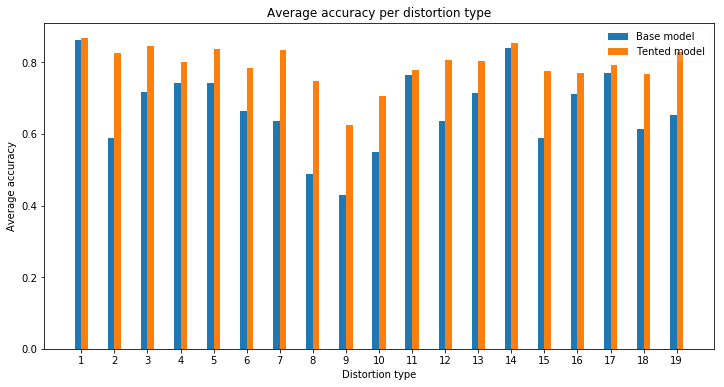

In [20]:
types = np.arange(1,20)

plt.figure(figsize=(12,6))
x_axis = np.arange(len(types))
plt.bar(x_axis -0.1, list1, width=0.2, label = 'Base model')
plt.bar(x_axis +0.1, list2, width=0.2, label = 'Tented model')

plt.xticks(x_axis, types)
plt.title("Average accuracy per distortion type")
plt.legend(loc = 'upper right', framealpha = 0.1)

plt.xlabel("Distortion type")
plt.ylabel("Average accuracy")
plt.savefig("cifar10c_vgg.pdf",bbox_inches = "tight")